# Keras Cyclical Learning Rate
> Keras Cyclical Learning Rate

- toc: true 
- badges: true
- comments: true
- categories: [Keras]
- image: images/chart-preview.png

In [41]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import cv2
import argparse
import numpy as np
#from resnet import ResNet
#from callbacks.epochcheckpoint import EpochCheckpoint
#from callbacks.trainingmonitor import TrainingMonitor
import os
import sklearn
import keras.backend as K
from sklearn.preprocessing import LabelBinarizer
from pysim.my_resnet import my_ResNet
from pysim import config
from pysim.clr_callback import CyclicLR
import matplotlib.pyplot as plt

## 1. Probleme mit herkömmlichen Lernraten

   - Wir wissen nicht was das optimale anfängliche Rate des Modelles ist
   - Eine monotone abnehmende Lernrate kann dazu führen dass unser Modell in Plateaus der Verlustsfunktion-Landschaft "stecken bleibt"
   
Stattdessen können wir zyklische Lernraten verwenden, um unsere Lernrate zwischen oberen und unteren Grenzen zu oszillieren, was uns Folgendes ermöglicht:

   - Mehr Freiheit bei der Wahl der anfänglichen Lernrate
   - Aus Sattelpunkten und lokalen Minima auszubrechen
   
   
## 2. Die zyklische Lernrate 
Die zyklische Lernrate verfolgen einen anderen Ansatz. Sie ist durch drei Paramter gekennzeichnet:
   -  Eine minimale Lernrate definieren
   -  Eine maximale Lernrate definieren
   -  Lernrate soll zyklisch zwischen den beiden Grenzen oszillieren
   
In der Praxis führt die Anwendung zyklischer Lernraten zu schnellerer Konvergenz, und das wird erzielt mit weniger Experimenten/Hyperparameter-Updates. 
Wenn man eine zyklische Lernrate im Kombination mit dem initial learning rate Ansatz verwenden führt dies zu einer Situation, in der fürs Modell nur sehr wening Feinsteurung den Parametern notwendig sei. 

![](images/cyclical_learningRate.png)

## 3. Die "dreieckige" Politik

![](images/triangular_policy.png)

## 4. Die "dreieckige2" Politik
![](images/triangular2_policy.png)

## 5. Die "exp_range" Politik
![](images/exp_range_policy.png)

Um die Implementierung verwenden zu können müssen wir erst einige Parameter defineren:
 - Batch size: Anzahl der Trainings-Beispiele, die in einem einzigen Vorwärts- und Rückwärtsdurchlauf des Modelles während des Trainings verwendet werden sollen
 - Batch/Iteration: Number of weight updates per epoch (i.e., # of total training examples divided by the batch size).
 - Cycle: Number of iterations it takes for our learning rate to go from the lower bound, ascend to the upper bound, and then descend back to the lower bound again.
 - Step size: Number of iterations in a half cycle. Leslie Smith, the creator of CLRs, recommends that the step_size should be (2-8) * training_iterations_in_epoch). In practice, a step sizes of either 4 or 8 work well in most situations.
 
 NUM_CLR_CYCLES = NUM_EPOCHS / STEP_SIZE / 2

In [26]:
(trainX, trainy), (testX, testy) = mnist.load_data()
print(trainX.shape, trainy.shape, testX.shape, testy.shape)
trainX, trainy, testX, testy = trainX[:100, :, :], trainy[:100], testX[:100, :, :], testy[:100,]
# resize images to dimension required by model
trainX = np.array([cv2.resize(image, (32, 32)) for image in trainX])
testX  = np.array([cv2.resize(image, (32, 32)) for image in testX])
# scale images between 0-1 floats
trainX = trainX.astype("float32")/255.
testX  = testX.astype("float32")/255.
# reshape (batch, size1, size2, 1)
trainX = np.reshape(trainX, (len(trainX), 32, 32, 1))
testX  = np.reshape(trainX,  (len(trainX), 32, 32, 1))
print(trainX.shape, trainy.shape, testX.shape, testy.shape)
# binarizer of y-label
lb = LabelBinarizer()
trainy = lb.fit_transform(trainy)
testy = lb.transform(testy)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(100, 32, 32, 1) (100,) (100, 32, 32, 1) (100,)


In [31]:
model = my_ResNet(10)
optimizer = tf.keras.optimizers.SGD(lr = 0.001)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])

In [36]:
print("[INFO] using '{}' method".format(config.CLR_METHOD))
clr = CyclicLR( mode=config.CLR_METHOD, base_lr=config.MIN_LR,\
               max_lr=config.MAX_LR,step_size= config.STEP_SIZE * (trainX.shape[0] // config.BATCH_SIZE))

[INFO] using 'triangular' method


In [43]:
H = model.fit(trainX, trainy, batch_size = config.BATCH_SIZE,
          validation_data = (testX, testy),\
          steps_per_epoch = trainX.shape[0] / config.BATCH_SIZE,
          epochs = config.NUM_EPOCHS, callbacks = [clr], 
          verbose = 1)

Epoch 1/96
2/1 [======================================] - 0s 176ms/step - loss: 0.3111 - accuracy: 0.4800 - val_loss: 0.3462 - val_accuracy: 0.0200
Epoch 2/96
2/1 [======================================] - 1s 277ms/step - loss: 0.3111 - accuracy: 0.4500 - val_loss: 0.3463 - val_accuracy: 0.0200
Epoch 3/96
2/1 [======================================] - 0s 182ms/step - loss: 0.3114 - accuracy: 0.4900 - val_loss: 0.3463 - val_accuracy: 0.0200
Epoch 4/96
2/1 [======================================] - 0s 165ms/step - loss: 0.3103 - accuracy: 0.5000 - val_loss: 0.3462 - val_accuracy: 0.0200
Epoch 5/96
2/1 [======================================] - 0s 218ms/step - loss: 0.3093 - accuracy: 0.4500 - val_loss: 0.3462 - val_accuracy: 0.0200
Epoch 6/96
2/1 [======================================] - 0s 248ms/step - loss: 0.3088 - accuracy: 0.4600 - val_loss: 0.3462 - val_accuracy: 0.0200
Epoch 7/96
2/1 [======================================] - 0s 210ms/step - loss: 0.3083 - accuracy: 0.4500 - val_

In [44]:
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=config.BATCH_SIZE)
#print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=config.CLASSES))

[INFO] evaluating network...


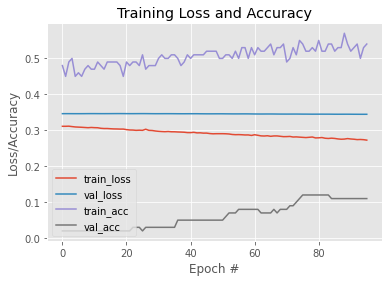

In [45]:
# plot the training loss and accuracy
N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(config.TRAINING_PLOT_PATH)

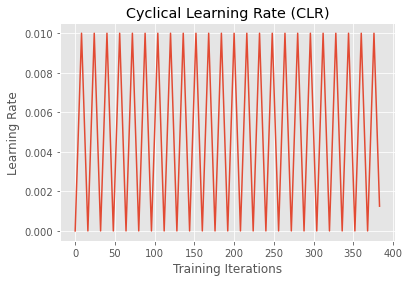

In [46]:
# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig(config.CLR_PLOT_PATH)

## References

> Adrian Rosebrock, OpenCV Face Recognition, PyImageSearch, https://www.pyimagesearch.com/, accessed on 3, January, 2021


> www: https://www.pyimagesearch.com/2019/10/07/is-rectified-adam-actually-better-than-adam/